In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wrangling

In [2]:
df = pd.read_csv('Data/nfl_player_stats_by_career_2020.csv')

In [3]:
# set option so I'm able to see all my columns
pd.set_option('display.max_columns', None)

#I've filtered out non-QBs by including only player's who've thrown over 1000 passes in there career
# in the modern nfl a quarter back will throw 1000 passes in about 3 seasons.
qb_df = df[df['attempted_passes'] > 800]

#dropped all columns that do not pertain to QBs.
qb_df = qb_df.dropna(axis=1)

#dropped unnecessary columns
qb_df.drop(columns=['id', 'sacks', 'year', 'fumbles_recovered', 'fumbles_recovered_for_touchdown', 
                    'longest_pass', 'longest_rush', 'touches', 'yards_lost_to_sacks', 'yards_per_touch',
                    'yards_recovered_from_fumble', 'birth_date', 'height', 'weight', 'season', 'approximate_value'], inplace=True, errors='ignore')


#split-up and dropped the qb_record column
#qb_df[['win','loss', 'tie']] = qb_df['qb_record'].str.split('-',expand=True)

#qb_df = qb_df.astype({'win': 'int64', 'loss': 'int64','tie': 'int64'})

qb_df.drop(columns=['qb_record'], inplace=True)

In [4]:
#import and wrangler HOF csv.
hof = pd.read_csv('Data/Hall of Fame List.csv')

hof['hof'] = 1

hof = hof[['name', 'hof']]

hof

,name,hof
0,Steve Atwater,1
1,Isaac Bruce,1
2,Harold Carmichael,1
3,Jimbo Covert,1
4,Bobby Dillon,1
...,...,...
289,Cal Hubbard,1
290,Don Hutson,1
291,Bronko Nagurski,1
292,Ernie Nevers,1


In [5]:
#merged qb and HOF datasets
qb_df = pd.merge(qb_df, hof, on='name', how='left')

qb_df.set_index('player_id', inplace=True)

In [6]:
#data cleaning
qb_df.drop(columns='name', inplace=True)
qb_df['hof'] = qb_df['hof'].replace(np.NaN, 0)

In [7]:
#import/wrangle/merge player season data to get years played in NFL
sdf = pd.read_csv('Data/nfl_player_stats_by_season_2020.csv')

sdf_qb = sdf[sdf['player_id'].isin(qb_df.index)]

sdf_pb_group = sdf_qb.groupby('player_id').agg(start_year = ('season' , 'min'), end_year = ('season', 'max'))

qb_df = pd.merge(qb_df, sdf_pb_group, on='player_id', how='left')

#filtered out active/ineligible QBs from the data set
test = qb_df[qb_df['end_year'] >= 2015]
qb_df = qb_df[qb_df['end_year'] < 2015]

# Train/Test Split

In [8]:
target = 'hof'
y = qb_df[target]
X = qb_df.drop(columns=target)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2)

# Baseline

In [10]:
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.8827586206896552


# Build Model - Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
forest_model = RandomForestClassifier(max_depth=2, n_estimators=500)

forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=500)

In [52]:
print('FOREST: Training Accuracy:', forest_model.score(X_train, y_train))
print('FOREST: VAl Accuracy:', forest_model.score(X_val, y_val))

FOREST: Training Accuracy: 0.9655172413793104
FOREST: VAl Accuracy: 0.918918918918919


# See Predictions

In [43]:
X_test = test.drop(columns=target)

In [44]:
y_pred_forest = forest_model.predict(X_test)

results = pd.DataFrame(y_pred_forest, columns=['hof'], index=X_test.index)

results[results['hof'] == 1]

,hof
player_id,
WilsRu00,1.0
BreeDr00,1.0
RodgAa00,1.0
BradTo00,1.0
RivePh00,1.0
RyanMa00,1.0
RoetBe00,1.0
StafMa00,1.0
MannEl00,1.0


# Feature Importance

Text(0.5, 0, 'Information Gain')

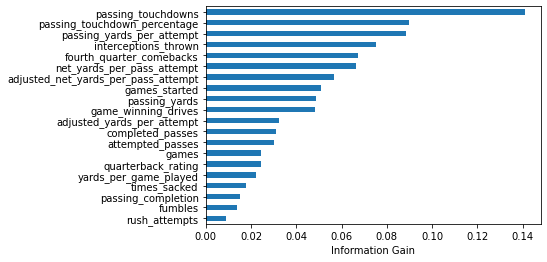

In [45]:
features = X_train.columns
importances = forest_model.feature_importances_

feature_importances = pd.Series(importances, index=features).sort_values()

feature_importances.tail(20).plot(kind='barh')
plt.xlabel('Information Gain')

# Permutation Importance

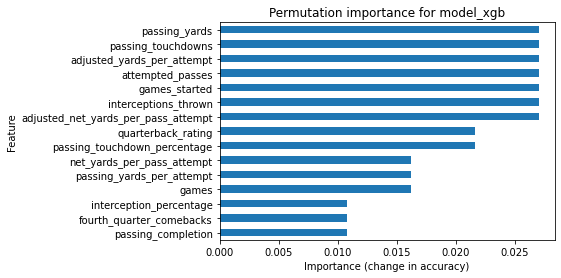

In [48]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(forest_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

# Build Model - XGBoost

In [16]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
boost_model = XGBClassifier(n_estimators=500, n_jobs=-1, random_state=42)

boost_model.fit(X_train, y_train);

In [36]:
print('Training accuracy:', boost_model.score(X_train, y_train))
print('Val accuracy:', boost_model.score(X_val, y_val))

Training accuracy: 1.0
Val accuracy: 0.8918918918918919


In [37]:
y_pred_boost = boost_model.predict(X_test)

results2 = pd.DataFrame(y_pred_boost, columns=['hof'], index=X_test.index)

In [38]:
results2[results2['hof'] == 1]

,hof
player_id,
WilsRu00,1.0
BreeDr00,1.0
RodgAa00,1.0
BradTo00,1.0
RivePh00,1.0
RyanMa00,1.0
RoetBe00,1.0
PalmCa00,1.0
RomoTo00,1.0


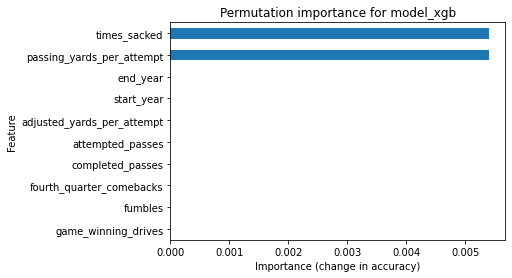

In [39]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(boost_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(10).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

# Random Forest with K-folds

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [24]:
forest_model = RandomForestClassifier()

param_space = {"criterion": ['gini', 'entropy'],
         "max_depth": [1, 2, 3, 4],
         "min_samples_leaf": [2, 3, 4],
         "min_samples_split": [2, 3, 4],
         "n_estimators": [100, 200, 300],
         "max_samples" : [0.5, 0.6, 0.7, 0.8, 0.9, 1]
 }

forest_rand_search = RandomizedSearchCV(forest_model, param_distributions=param_space, n_iter=20,
                                         scoring="accuracy", verbose=True, cv=StratifiedKFold(n_splits=5),
                                         n_jobs=-1, random_state=42)

forest_rand_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4],
                                        'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                        1],
                                        'min_samples_leaf': [2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=True)

In [25]:
forest_rand_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_samples': 0.7,
 'max_depth': 1,
 'criterion': 'gini'}

In [26]:
forest_rand_search.best_score_

0.9177177177177176

In [27]:
y_pred_tree = forest_rand_search.predict(X_test)

results1 = pd.DataFrame(y_pred_tree, columns=['hof'], index=X_test.index)